# Exploratory Analysis of Fund 5 CA Assessments

## Load packages.

In [1]:
require(data.table)
require(magrittr)

require(ggplot2)

Loading required package: data.table
Loading required package: magrittr
Loading required package: ggplot2


In [2]:
options(repr.plot.height=4)

## Read data.

### Read CA assessments.

In [3]:
assessments <- fread("f5-assessments.tsv")
assessments %>% summary

 Unique Proposal ID     CA ID         Proposal ID      Question ID   
 Length:5416        Min.   :  1.00   Min.   :350599   Min.   :1.000  
 Class :character   1st Qu.: 22.00   1st Qu.:350984   1st Qu.:1.000  
 Mode  :character   Median : 46.00   Median :352002   Median :2.000  
                    Mean   : 62.14   Mean   :351793   Mean   :2.348  
                    3rd Qu.: 71.00   3rd Qu.:352549   3rd Qu.:3.000  
                    Max.   :255.00   Max.   :352830   Max.   :6.000  
     Score        Flagged       
 Min.   :1.000   Mode :logical  
 1st Qu.:2.000   FALSE:4172     
 Median :4.000   TRUE :1244     
 Mean   :3.299                  
 3rd Qu.:5.000                  
 Max.   :5.000                  

### Read which proposals belong to which challenges.

In [4]:
challenges <- fread("f5-challenges.tsv")
challenges %>% summary

  Challenge          Proposal ID     Short Title       
 Length:321         Min.   :350599   Length:321        
 Class :character   1st Qu.:351008   Class :character  
 Mode  :character   Median :352005   Mode  :character  
                    Mean   :351820                     
                    3rd Qu.:352562                     
                    Max.   :355448                     

### Check to make sure that every proposal belongs to a challenge.

In [5]:
setdiff(assessments$`Proposal ID`, challenges$`Proposal ID`)

integer(0)

### Join the assessment data with the challenge data.

In [6]:
f5 <- merge(assessments, challenges, allow.cartesian=TRUE)
f5[1:10, ]

Proposal ID,Unique Proposal ID,CA ID,Question ID,Score,Flagged,Challenge,Short Title
<int>,<chr>,<int>,<int>,<int>,<lgl>,<chr>,<chr>
350599,UM5UZBiNh,1,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,2,1,3,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,9,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,11,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,13,1,4,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,14,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,15,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,16,1,5,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code
350599,UM5UZBiNh,18,1,4,TRUE,Developer Ecosystem,Step by Step Guide Off Chain Code


## CA activity by number of assessments and challenges.

In [7]:
f5.assessments_by_ca <- f5[, .(
    `Number of Assessments` = .N,
    `Number of Challenges` = factor(length(unique(`Challenge`)), levels=1:10)
), by = `CA ID`]
f5.assessments_by_ca %>% summary

     CA ID       Number of Assessments Number of Challenges
 Min.   :  1.0   Min.   :  1.00        1      :44          
 1st Qu.: 54.5   1st Qu.:  6.00        2      :35          
 Median :126.5   Median : 12.00        3      :22          
 Mean   :122.1   Mean   : 39.25        8      :11          
 3rd Qu.:183.8   3rd Qu.: 30.00        4      :10          
 Max.   :255.0   Max.   :798.00        6      : 6          
                                       (Other):10          

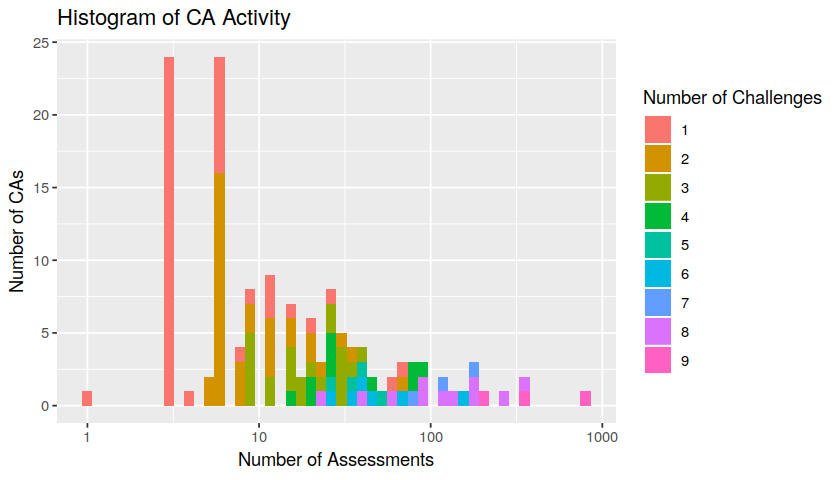

In [8]:
ggplot(f5.assessments_by_ca, aes(x = `Number of Assessments`,fill = `Number of Challenges`)) +
    geom_histogram(bins = 50) +
    scale_x_log10() +
    ylab("Number of CAs") +
    ggtitle("Histogram of CA Activity")

## Looking for simple suspicious patterns of scores.

### CAs whose only five-star scores went to a single proposal.

In [9]:
f5.five_stars_only_one <- f5[
    `Score` == 5,
    .(`Number of Unique Proposals` = length(unique(`Unique Proposal ID`))),
    by = `CA ID`
][`Number of Unique Proposals` == 1, .(`CA ID`)]
f5.five_stars_only_one

CA ID
<int>
64
146
115
128
132
130
138
157
158


#### How they scored other proposals.

In [10]:
f5.score_by_ca <- merge(
    f5.assessments_by_ca[`CA ID` %in% f5.five_stars_only_one[, `CA ID`], .(`CA ID`, `Number of Challenges`)],
    dcast(f5[, .N, by = .(`CA ID`, `Score`)], `CA ID` ~ `Score`, value.var = "N", fill = 0),
    by = "CA ID"
)
colnames(f5.score_by_ca) <- c("CA ID", "Number of Challenges", "Score 1", "Score 2", "Score 3", "Score 4", "Score 5")
f5.score_by_ca[order(`Number of Challenges`, - `Score 1`, - `Score 2`, - `Score 3`, - `Score 4`)]

CA ID,Number of Challenges,Score 1,Score 2,Score 3,Score 4,Score 5
<int>,<fct>,<int>,<int>,<int>,<int>,<int>
64,1,3,0,0,1,2
255,1,0,1,1,2,2
229,1,0,1,1,0,1
190,1,0,0,2,3,1
128,1,0,0,1,3,2
254,1,0,0,1,1,1
115,1,0,0,0,1,2
182,1,0,0,0,1,2
138,1,0,0,0,0,3


#### Cases where the CA scored one proposal highly, and all other proposals received low scores.

In [11]:
f5[`CA ID` %in% c(64,254,182,115)][order(`CA ID`, `Unique Proposal ID`, `Question ID`)]

Proposal ID,Unique Proposal ID,CA ID,Question ID,Score,Flagged,Challenge,Short Title
<int>,<chr>,<int>,<int>,<int>,<lgl>,<chr>,<chr>
350661,UM5UZBiOi,64,1,5,FALSE,DApps Integrations,ChainEscrow On chain escrow dApp
350661,UM5UZBiOi,64,2,4,FALSE,DApps Integrations,ChainEscrow On chain escrow dApp
350661,UM5UZBiOi,64,3,5,FALSE,DApps Integrations,ChainEscrow On chain escrow dApp
351002,UM5UZBiUI,64,1,1,FALSE,DApps Integrations,Decentralised maps and nfts
351002,UM5UZBiUI,64,2,1,FALSE,DApps Integrations,Decentralised maps and nfts
351002,UM5UZBiUI,64,3,1,FALSE,DApps Integrations,Decentralised maps and nfts
350764,UM5UZBiQO,115,1,5,FALSE,Grow Africa,Planting Roots In Africa
350764,UM5UZBiQO,115,2,4,FALSE,Grow Africa,Planting Roots In Africa
350764,UM5UZBiQO,115,3,5,FALSE,Grow Africa,Planting Roots In Africa


#### Cases where the CA scored only one proposal and gave it five stars.

In [12]:
f5.score_by_ca[`Score 1` + `Score 2` + `Score 3` + `Score 4` == 0, .(`CA ID`)]

CA ID
<int>
138
158
159
161
166
169
172
212
218
